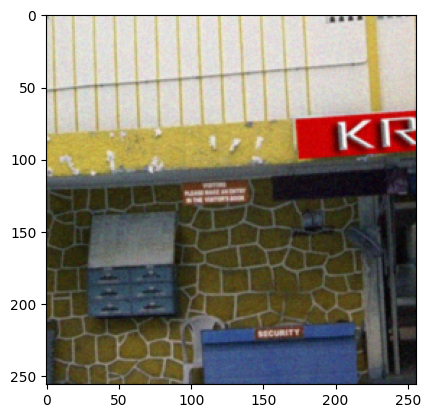

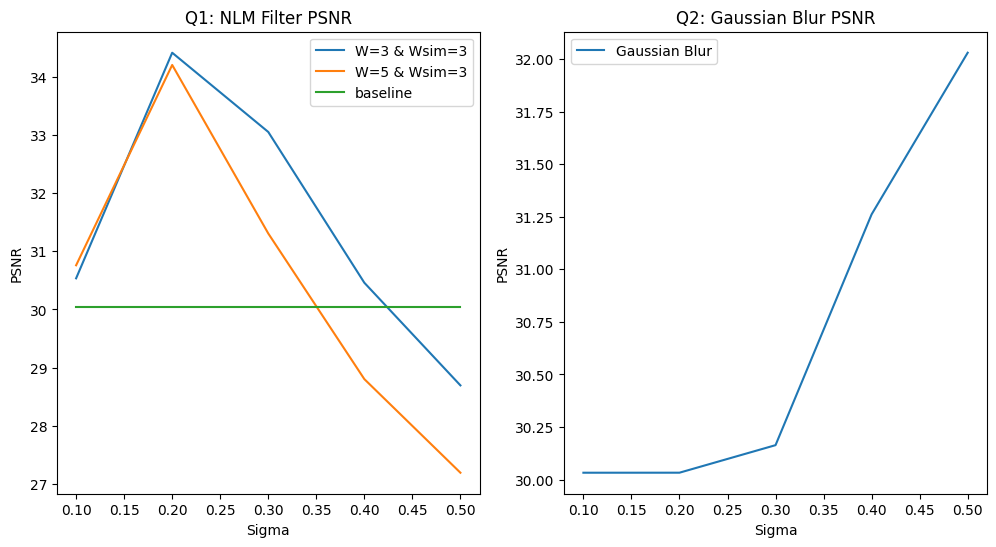

In [3]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt

def calculate_gaussian(V_p, V_q ,sigma = 1.0):
    diff = np.linalg.norm(V_p - V_q)
    return np.exp(-diff**2 / (2 * sigma**2))

def nlm_filter(image, W, W_sim, sigma):
    pad_size = W + W_sim
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), 'constant', constant_values=0)
    filtered_image = np.zeros_like(image)
    for channel in range(3):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                weights = []
                img_patch = []
                m, n = i + pad_size, j + pad_size
                p = padded_image[m - W_sim:m + W_sim + 1, n - W_sim:n + W_sim + 1, channel]
                p = p.flatten()
                for x in range(m - W, m + W + 1):
                    for y in range(n - W, n + W + 1):
                        q = padded_image[x - W_sim:x + W_sim + 1, y - W_sim:y + W_sim + 1, channel]
                        q = q.flatten()
                        index = len(q) // 2
                        q_ = q[index]
                        gaussian = calculate_gaussian(p, q, sigma)
                        weights.append(gaussian)
                        img_patch.append(q_)
                weights = weights / np.sum(weights)
                filtered_image[i, j, channel] = np.sum(np.dot(weights, img_patch))
    return filtered_image

def PSNR(org_img,filt_img):
    MSE=np.average((org_img-filt_img)**2)
    max1=org_img.max()
    return 10*np.log10((max1*max1)/MSE)

def make_kernel(sigma):
    k = int(np.ceil(6 * sigma))
    if k % 2 == 0:  # If k is even, make it odd by adding 1
        k += 1
    k_mid = k // 2
    gaussian_filter = np.zeros((k, k), np.float32)
    for y in range(-k_mid, k_mid + 1):
        for x in range(-k_mid, k_mid + 1):
            normal = 1 / (2 * np.pi * sigma**2)
            exp_term = np.exp(-(x**2 + y**2) / (2 * sigma**2))
            gaussian_filter[y + k_mid, x + k_mid] = normal * exp_term
    gaussian_filter = gaussian_filter / np.sum(gaussian_filter)  # to normalize the gaussian filter
    return gaussian_filter

def pad(sigma, image):
    h, w = image.shape[:2]
    k = int(np.ceil(6 * sigma) + 1)
    output_image = np.zeros((h, w, 3), dtype=np.float32)
    output_image = np.pad(image, ((int((k - 1) / 2), int((k - 1) / 2)), 
                                  (int((k - 1) / 2), int((k - 1) / 2)), 
                                  (0, 0)), 'constant')
    return output_image

def convolution(img, sigma):
    kernel = make_kernel(sigma)
    pad = kernel.shape[0] // 2
    padded_image = np.zeros((img.shape[0] + 2 * pad, img.shape[1] + 2 * pad, 3))
    padded_image[pad:img.shape[0] + pad, pad:img.shape[1] + pad, :] = img
    conv_image = np.zeros((img.shape[0], img.shape[1], 3))
    for c in range(0, 3):
        for ii in range(img.shape[0]):
            for jj in range(img.shape[1]):
                i = ii + pad
                j = jj + pad
                img_bit = padded_image[i - pad:i + pad + 1, j - pad:j + pad + 1, c]
                cov = np.sum(img_bit * kernel)
                conv_image[ii, jj, c] = cov
    plt.imshow(conv_image)
    return conv_image

# Read the RGB image
krishna_g = cv.imread("/home/gadha/Desktop/Courses/ISP_2024/lab_10/krishna_0_001.png")
krishna_f = cv.imread("/home/gadha/Desktop/Courses/ISP_2024/lab_10/krishna.png")

# Convert the image to floating point format and normalize intensity range to [0, 1]
g = krishna_g.astype(float) / 255.0
f = krishna_f.astype(float) / 255.0

# Q1 parameters
sigma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
W1 = 3
W2 = 5
W_sim = 3
Images_1 = []
Images_2 = []
PSNR_1 = []
PSNR_2 = []
baseline_psnr = PSNR(f, g)
baseline_plot = np.ones(5) * baseline_psnr

# Q1: NLM filter
for sigma in sigma_values:   
    filter_img1 = nlm_filter(g, W1, W_sim, sigma)
    filter_img2 = nlm_filter(g, W2, W_sim, sigma)
    Images_1.append(filter_img1)
    Images_2.append(filter_img2)
    psnr_1 = PSNR(f, filter_img1)
    psnr_2 = PSNR(f, filter_img2)
    PSNR_1.append(psnr_1)
    PSNR_2.append(psnr_2)

# Q2 parameters
sigma = [0.1, 0.2, 0.3, 0.4, 0.5]
Psnr_gau = []
img_gau = []

# Q2: Convolution
for sig in sigma:
    Kernel = make_kernel(sig)
    cov_img = convolution(g, sig)
    psnr = PSNR(f, cov_img)
    img_gau.append(cov_img)
    Psnr_gau.append(psnr)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(sigma_values, PSNR_1, label='W=3 & Wsim=3')
plt.plot(sigma_values, PSNR_2, label='W=5 & Wsim=3')
plt.plot(sigma_values, baseline_plot, label='baseline')
plt.title('Q1: NLM Filter PSNR')
plt.xlabel('Sigma')
plt.ylabel('PSNR')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma, Psnr_gau, label='Gaussian Blur')
plt.title('Q2: Gaussian Blur PSNR')
plt.xlabel('Sigma')
plt.ylabel('PSNR')
plt.legend()

plt.show()


In [12]:
def generate_kernel(sigma, size):
    size = int(size)
    kernel = np.zeros((size, size))
    half_size = size // 2
    if sigma == 0:
        return np.array([1])
    for row in range(-half_size, half_size + 1):
        for col in range(-half_size, half_size + 1):
            part1 = np.pi * 2 * (sigma ** 2)
            distance = (row ** 2 + col ** 2) / (2 * sigma ** 2)
            part2 = np.exp(-distance)
            kernel[row + half_size, col + half_size] = part2 / part1
    kernel = kernel / np.sum(kernel)
    return kernel

In [39]:
import numpy as np

def gaussian_similarity(patch1, patch2, sigma):
    squared_diff = np.sum((patch1 - patch2) ** 2)
    similarity = np.exp(-squared_diff / (2 * sigma ** 2))
    return similarity

# def nlm_kernel(image, window_size, window_similarity, sigma, row, col):
#     kernel = np.zeros((2 * window_size + 1, 2 * window_size + 1, 3))
#     row_start, row_end = row - window_size, row + window_size
#     col_start, col_end = col - window_size, col + window_size
#     padding = window_size + window_similarity
    
#     for channel in range(3):
#         central_patch = image[row - window_similarity:row + window_similarity + 1, col - window_similarity:col + window_similarity + 1, channel]
#         central_patch = central_patch.flatten()
        
#         kernel_row = 0
#         for i in range(row_start, row_end + 1):
#             kernel_col = 0
#             for j in range(col_start, col_end + 1):
#                 neighbor_patch = image[i - window_similarity:i + window_similarity + 1, j - window_similarity:j + window_similarity + 1, channel]
#                 neighbor_patch = neighbor_patch.flatten()
                
#                 similarity = gaussian_similarity(central_patch, neighbor_patch, sigma)
#                 kernel[kernel_row, kernel_col, channel] = similarity
#                 kernel_col += 1
#             kernel_row += 1
        
#         kernel[:, :, channel] /= np.sum(kernel[:, :, channel])
    
#     return kernel


In [37]:
# def NLM_kernel(img,W,Wsim,sigma,i,j):
#     kernel=np.zeros((2*W+1,2*W+1,3))
#     r1,r2=i-W,i+W
#     c1,c2=j-W,j+W
#     pad=W+Wsim
#     img2=img[i-pad:i+pad,j-pad:j+pad,:]
#     plt.imshow(img2)
#     for c in range(0,3):
#         p=img[i-Wsim:i+Wsim+1,j-Wsim:j+Wsim+1,c]
#         p=p.flatten()
#         rr=0
#         cc=0
#         for ii in range(r1,r2+1):
#             for jj in range(c1,c2+1):
#                 q=img[ii-Wsim:ii+Wsim+1,jj-Wsim:jj+Wsim+1,c]
#                 q=q.flatten()
#                 gauss=gaussian_similarity(p,q,sigma)
#                 kernel[rr,cc,c]=gauss
#                 cc+=1
#             cc=0
#             rr+=1
#         kernel[:,:,c]=kernel[:,:,c]/np.sum(kernel[:,:,c])
#     return kernel

In [40]:
def nlm_kernel(image, window_size, window_similarity, sigma, row, col):
    # Initialize the kernel matrix
    kernel_matrix = np.zeros((2 * window_size + 1, 2 * window_size + 1, 3))
    
    # Calculate the row and column ranges for the patch
    row_start, row_end = row - window_size, row + window_size
    col_start, col_end = col - window_size, col + window_size
    
    # Padding size
    padding = window_size + window_similarity
    
    # Extract the patch of interest
    patch_of_interest = image[row - padding:row + padding, col - padding:col + padding, :]
    
    # Iterate over each channel
    for channel in range(3):
        # Extract the central patch and flatten it
        central_patch = image[row - window_similarity:row + window_similarity + 1,
                               col - window_similarity:col + window_similarity + 1, channel]
        central_patch = central_patch.flatten()
        
        # Initialize kernel row index
        kernel_row = 0
        
        # Iterate over rows
        for i in range(row_start, row_end + 1):
            # Initialize kernel column index
            kernel_col = 0
            
            # Iterate over columns
            for j in range(col_start, col_end + 1):
                # Extract the neighbor patch and flatten it
                neighbor_patch = image[i - window_similarity:i + window_similarity + 1,
                                       j - window_similarity:j + window_similarity + 1, channel]
                neighbor_patch = neighbor_patch.flatten()
                
                # Compute the similarity between the patches
                similarity = gaussian_similarity(central_patch, neighbor_patch, sigma)
                
                # Update the kernel matrix
                kernel_matrix[kernel_row, kernel_col, channel] = similarity
                
                # Increment the column index
                kernel_col += 1
            
            # Increment the row index
            kernel_row += 1
        
        # Normalize the kernel matrix for each channel
        kernel_matrix[:, :, channel] /= np.sum(kernel_matrix[:, :, channel])
    
    return kernel_matrix


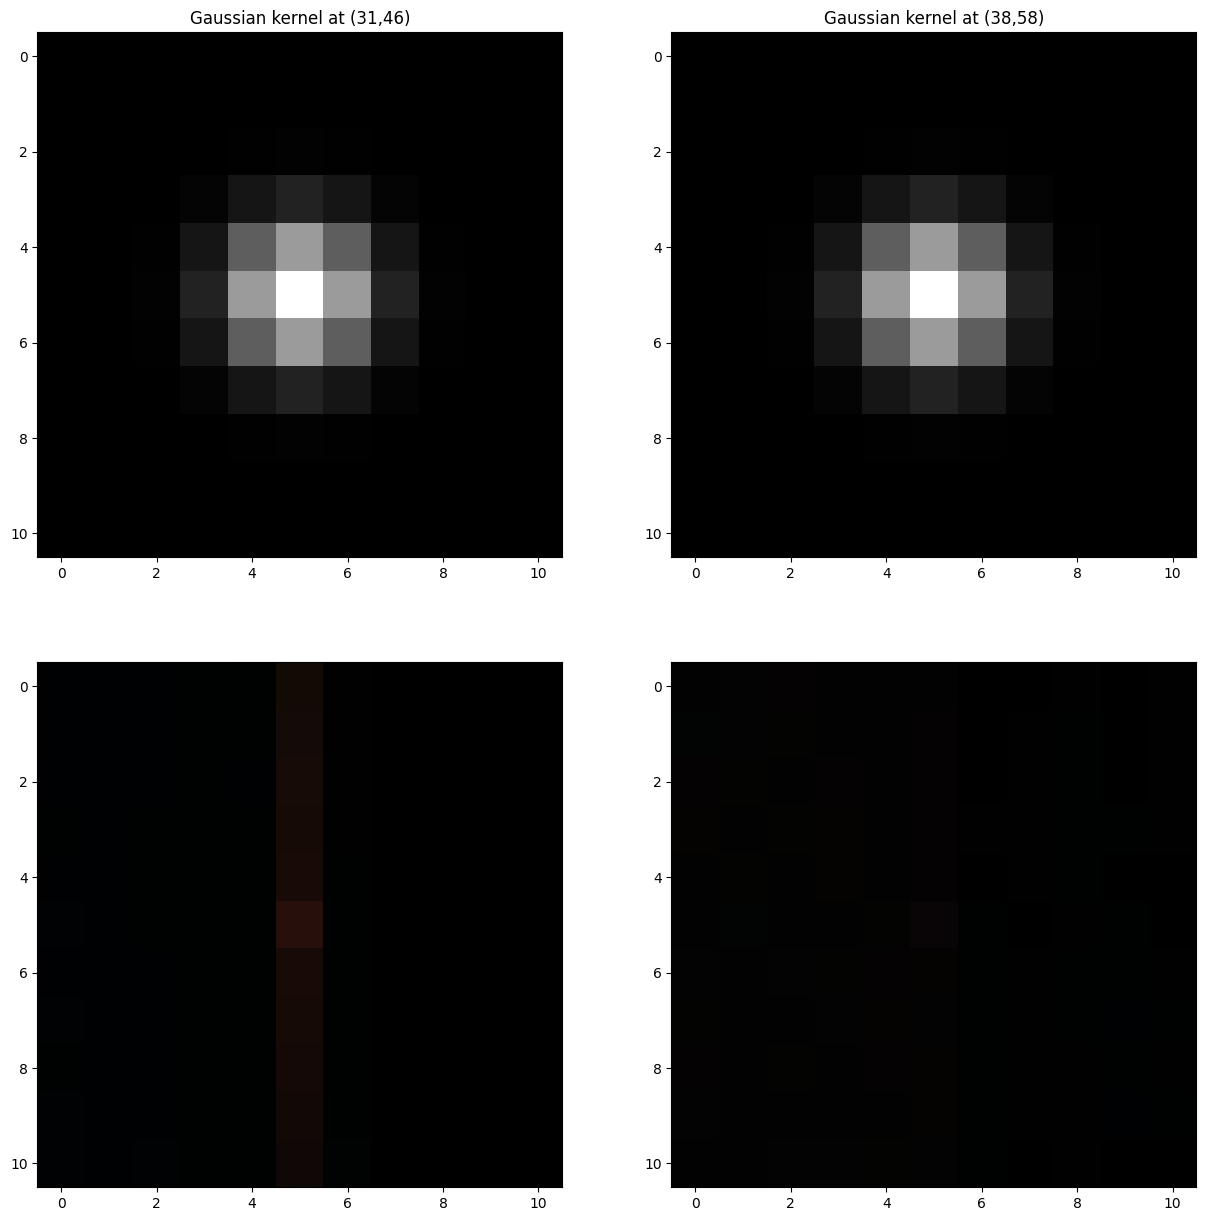

In [42]:
plt.figure(0,figsize=(15,15))
plt.subplot(221)
size=11
Kernel2=generate_kernel(1,size)
plt.imshow(Kernel2,cmap='gray')
plt.title('Gaussian kernel at (31,46)')

plt.subplot(222)

size=11
Kernel2=generate_kernel(1,size)
plt.imshow(Kernel2,cmap='gray')
plt.title('Gaussian kernel at (38,58)')

plt.subplot(223)
kernel1=nlm_kernel(g,5,3,.3,31,46)
plt.imshow(kernel1)

plt.subplot(224)
kernel1=nlm_kernel(g,5,3,.3,38,58)
plt.imshow(kernel1)


NameError: name 'Images_2' is not defined

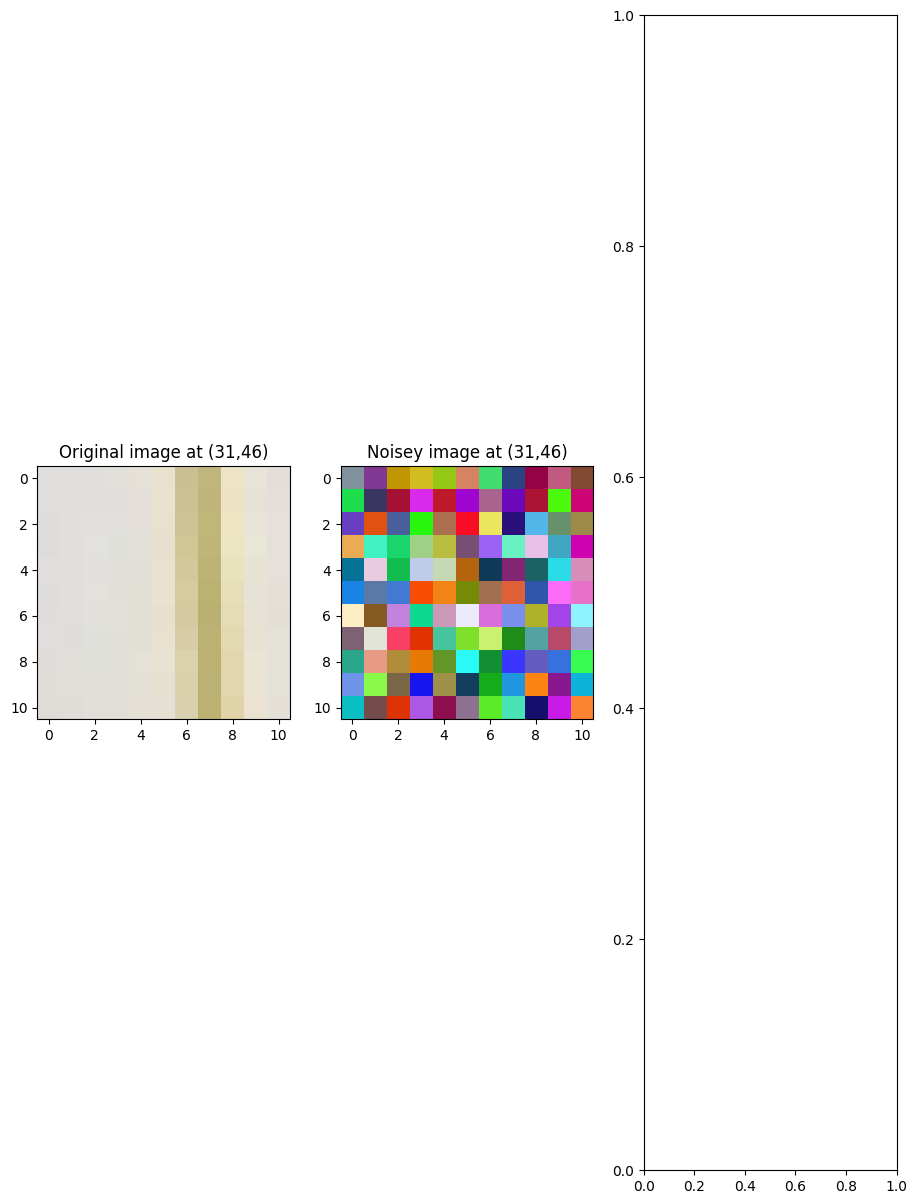

In [24]:
plt.figure(0,figsize=(15,15))
plt.subplot(141)
plt.imshow(f[31-5:31+5+1,46-5:46+5+1,:])
plt.title('Original image at (31,46)')

plt.subplot(142)
plt.imshow(g[31-5:31+5+1,46-5:46+5+1,:])
plt.title('Noisey image at (31,46)')
plt.subplot(143)
plt.imshow(Images_2[2][31-5:31+5+1,46-5:46+5+1,:])
plt.title('NLM Filtered image at (31,46)')

plt.subplot(144)
plt.imshow(img_gau[4][31-5:31+5+1,46-5:46+5+1,:])
plt.title('Gaussian Filtered image at (31,46)')